In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
nan = np.nan

In [2]:
import numpy.linalg

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
df = pd.read_csv('/Users/jonathan/Desktop/kalman sheets/50 mil.csv', skiprows=0)

In [13]:
df.columns = ['dt', 'obs_x', 'obs_y', 'obs_Vx', 'obs_Vy', 'est_x', 'est_y', 'est_Vx', 'est_Vy'     ]

In [15]:
df['obs_Vx'] = np.abs(df.obs_Vx)

TypeError: bad operand type for abs(): 'str'

In [16]:
ax = df.plot(x='obs_x', y='obs_y', figsize=(16,10))
df.plot(x='est_x', y='est_y', ax=ax, style='g--')

TypeError: no numeric data to plot

In [17]:
df[['est_Vx', 'obs_Vx']].plot(figsize=(16,10))

TypeError: no numeric data to plot

In [18]:
df[['est_x', 'obs_x']].plot(figsize=(16,10))

TypeError: no numeric data to plot

In [19]:
mx = df[['obs_x', 'obs_y', 'obs_Vx', 'obs_Vy']]

In [20]:
# SimpleMatrix x_k_est = F.mult(x_k_1);
# SimpleMatrix P_k_est = F.mult(P_k_1).mult(F.transpose()).plus(Q);

# SimpleMatrix S_k = H.mult(P_k_est).mult(H.transpose()).plus(R);
# SimpleMatrix K = P_k_est.mult(H.transpose().mult(S_k.invert()));

# SimpleMatrix y_k = z_k.minus(H.mult(x_k_est));
# SimpleMatrix x_k = x_k_est.plus(K.mult(y_k));
# SimpleMatrix P_k = (I.minus(K.mult(H))).mult(P_k_est);

def KF_Update(Z, x, P, u):
    x = F * x + np.dot(B, u )
    #print("x'=", x.T)
    P = F*P*F.T + Q

    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = P * H.T * numpy.linalg.inv(S)

    # Update the estimate via z
    y = Z - (H*x) # Innovation or Residual
    #print("y =", y.T)
    x = x + (K*y)

    # Update the error covariance
    P = (I - (K*H))*P

    return x, P

In [21]:
x0 = np.matrix([0, 0, 0, 0]).T
P0 = np.matrix([
    [0.1, 0, 0, 0],
    [0, 0.1, 0, 0],
    [0, 0, 0.1, 0],
    [0, 0, 0, 0.1]
])

In [22]:
dt = 0.050
F = np.matrix([
    [1, 0, dt, 0],
    [0, 1, 0, dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

G = np.matrix([0.5*dt*dt, 0.5*dt*dt, dt, dt])
sigma_a = 0.005

Q = sigma_a* sigma_a * G * G.T 

H = np.eye(F.shape[0])

positionVar = 0.005
velocityVar = 0.001
R = np.matrix([
    [positionVar, 0, 0, 0],
    [0, positionVar, 0, 0],
    [0, 0, velocityVar, 0],
    [0, 0, 0, velocityVar]
])

I = numpy.eye(F.shape[0])
theta = 0
B = np.matrix([
    [dt*dt/2*np.cos(theta), 0,                     0,                     0],
    [0,                     dt*dt/2*np.sin(theta), 0,                     0],
    [0,                     0,                     dt*dt/2*np.cos(theta), 0],
    [0,                     0,                     0,                     dt*np.sin(theta)]
])
a_x = 20
a_y = 20
u_u = np.matrix([a_x, a_y,a_x, a_y]).T
u_0 = np.matrix([0, 0, 0, 0]).T

In [23]:
Q

matrix([[1.25078125e-07]])

In [24]:
x = x0
P = P0
data = []
for r in mx.iterrows():
    z = np.matrix(r[1]).T
    #print("z =",z.T)
    v = np.sqrt(np.dot(z[2:4].T, z[2:4]))
    #print(v, z[2])
    u = u_u if v < 5000 else u_0
    x, P = KF_Update(z, x, P, u)
    #print("x =", x.T)
    data.append(x.T[0]) 
    #print()

TypeError: can't multiply sequence by non-int of type 'str'

In [230]:
df_est = pd.DataFrame([x.tolist()[0] for x in data], columns=['est_x', 'est_y', 'est_Vx', 'est_Vy'])

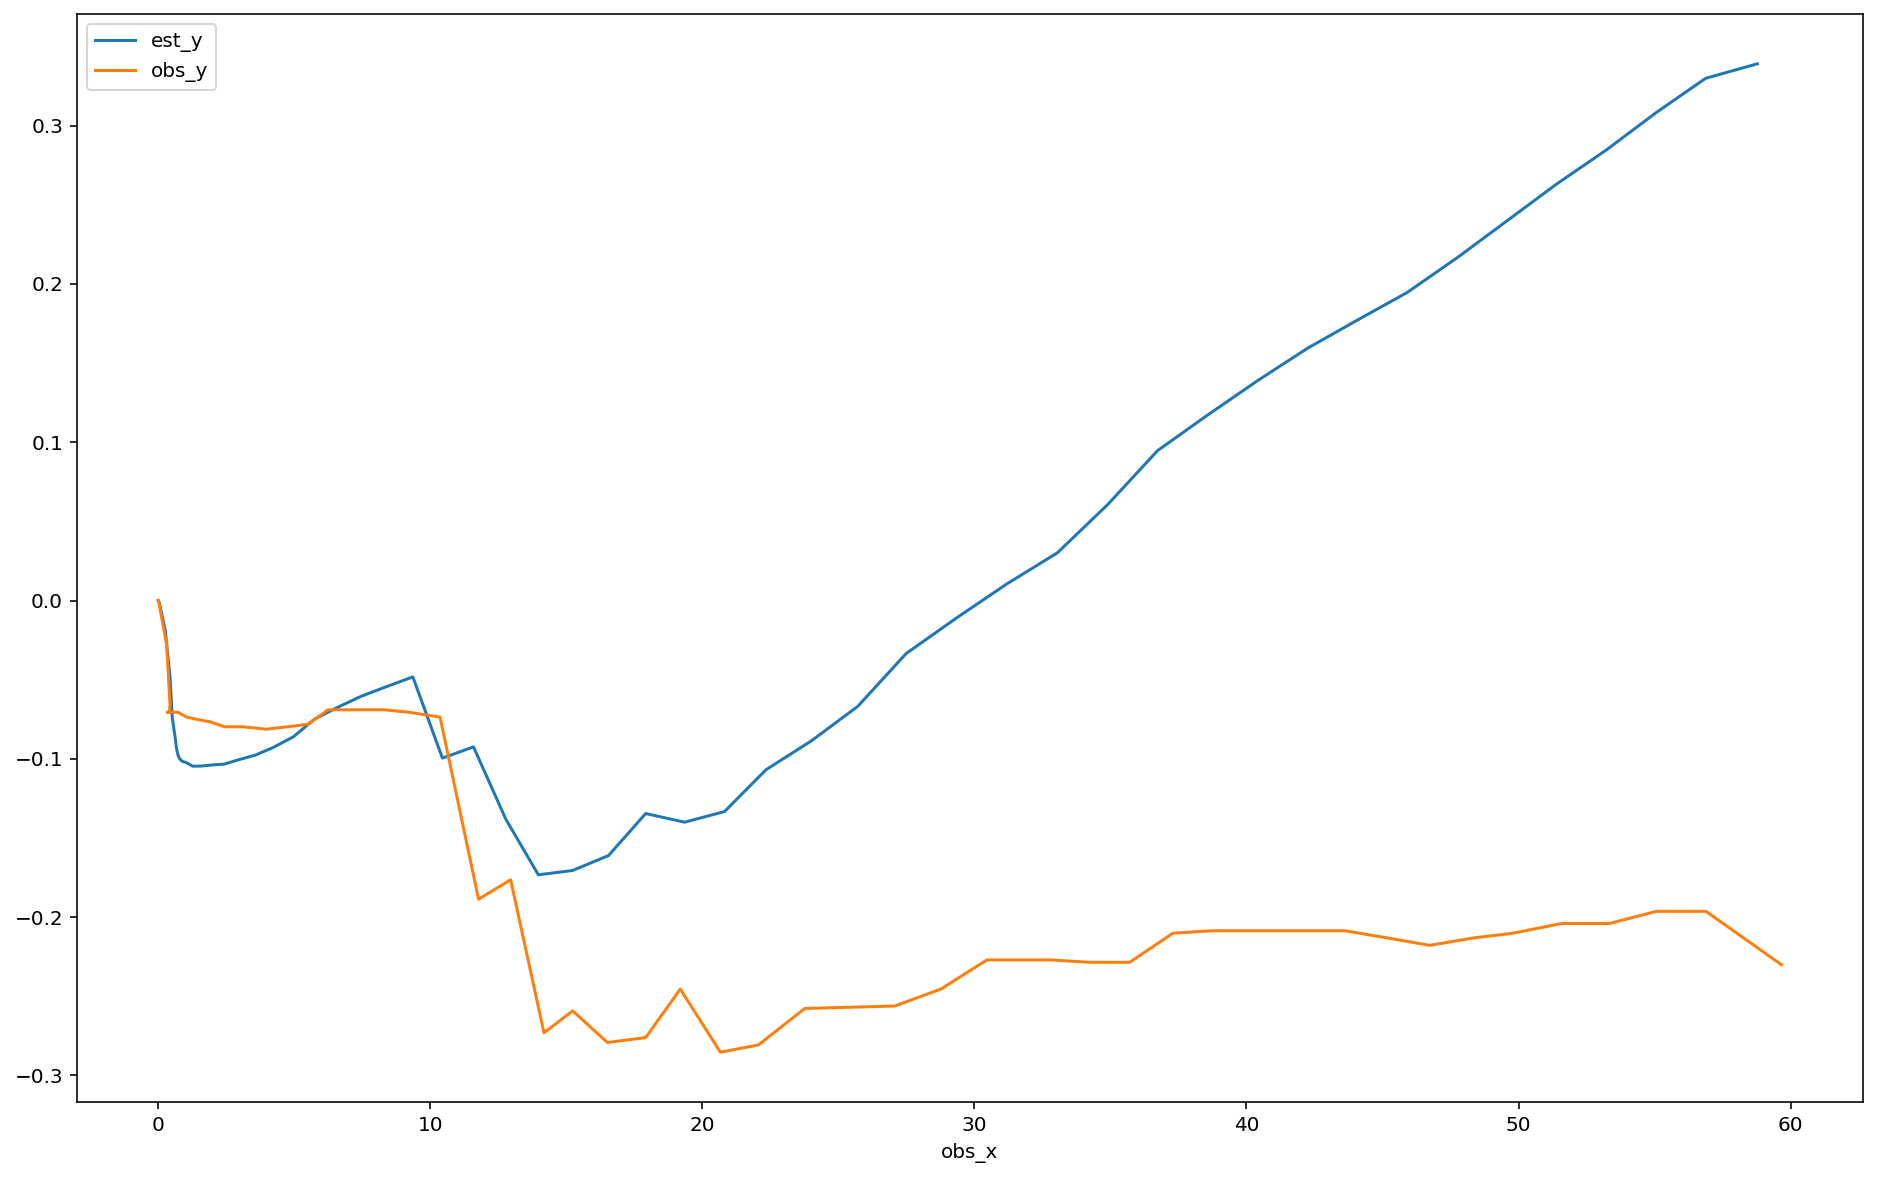

In [231]:
ax = df_est.plot(x='est_x', y='est_y', figsize=(16,10))
mx.plot(x='obs_x', y='obs_y', ax=ax)

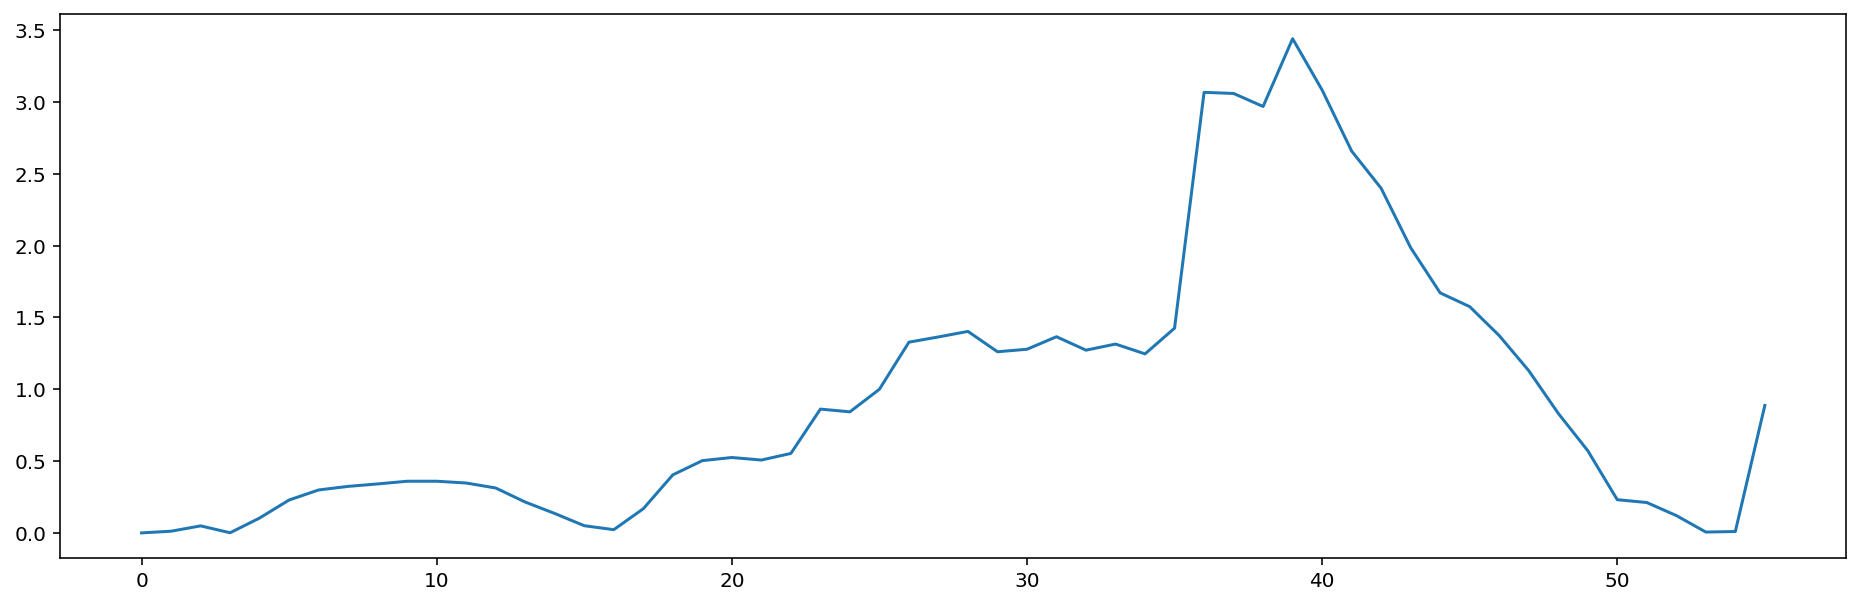

In [237]:
np.abs(df_est.est_x-mx.obs_x).plot(figsize=(16,5))

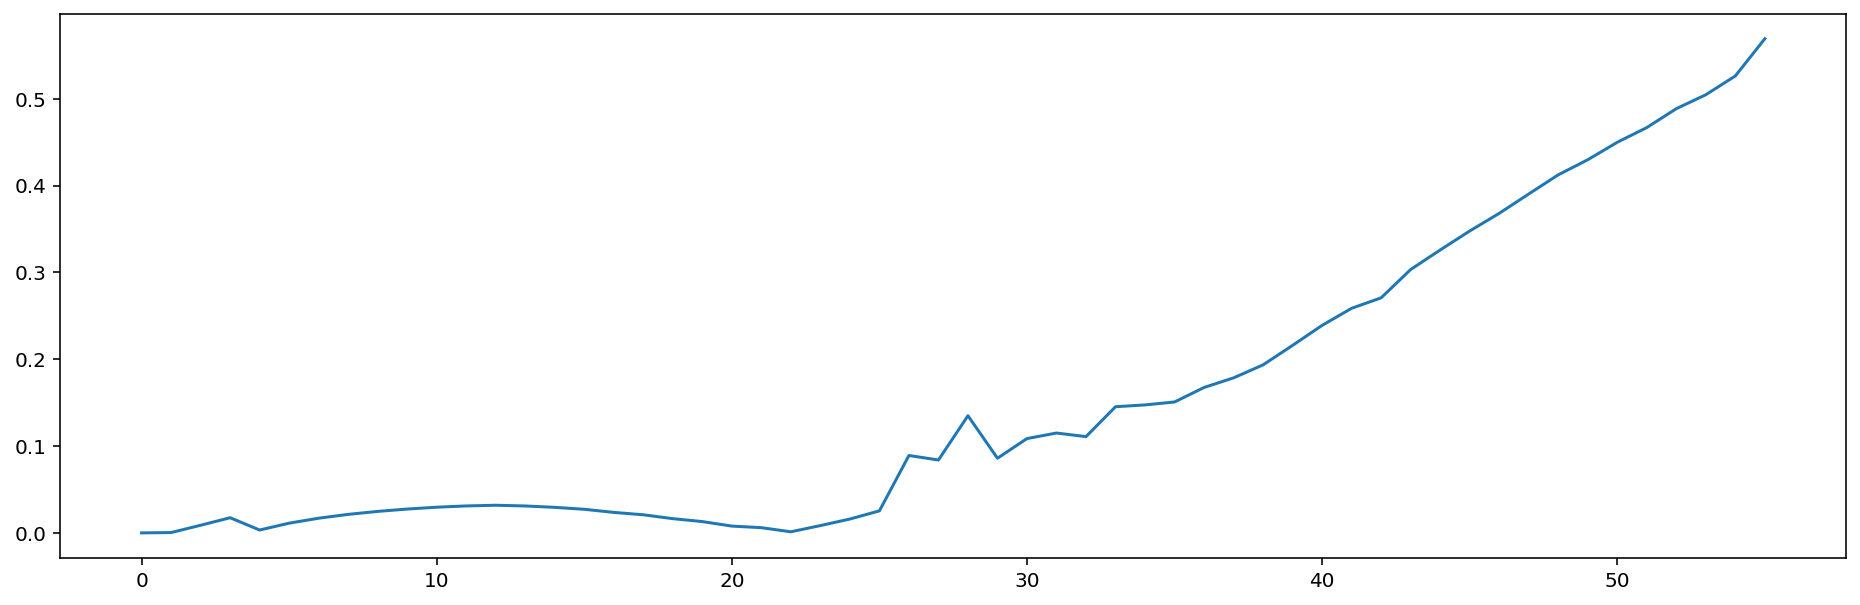

In [236]:
np.abs(df_est.est_y-mx.obs_y).plot(figsize=(16,5))

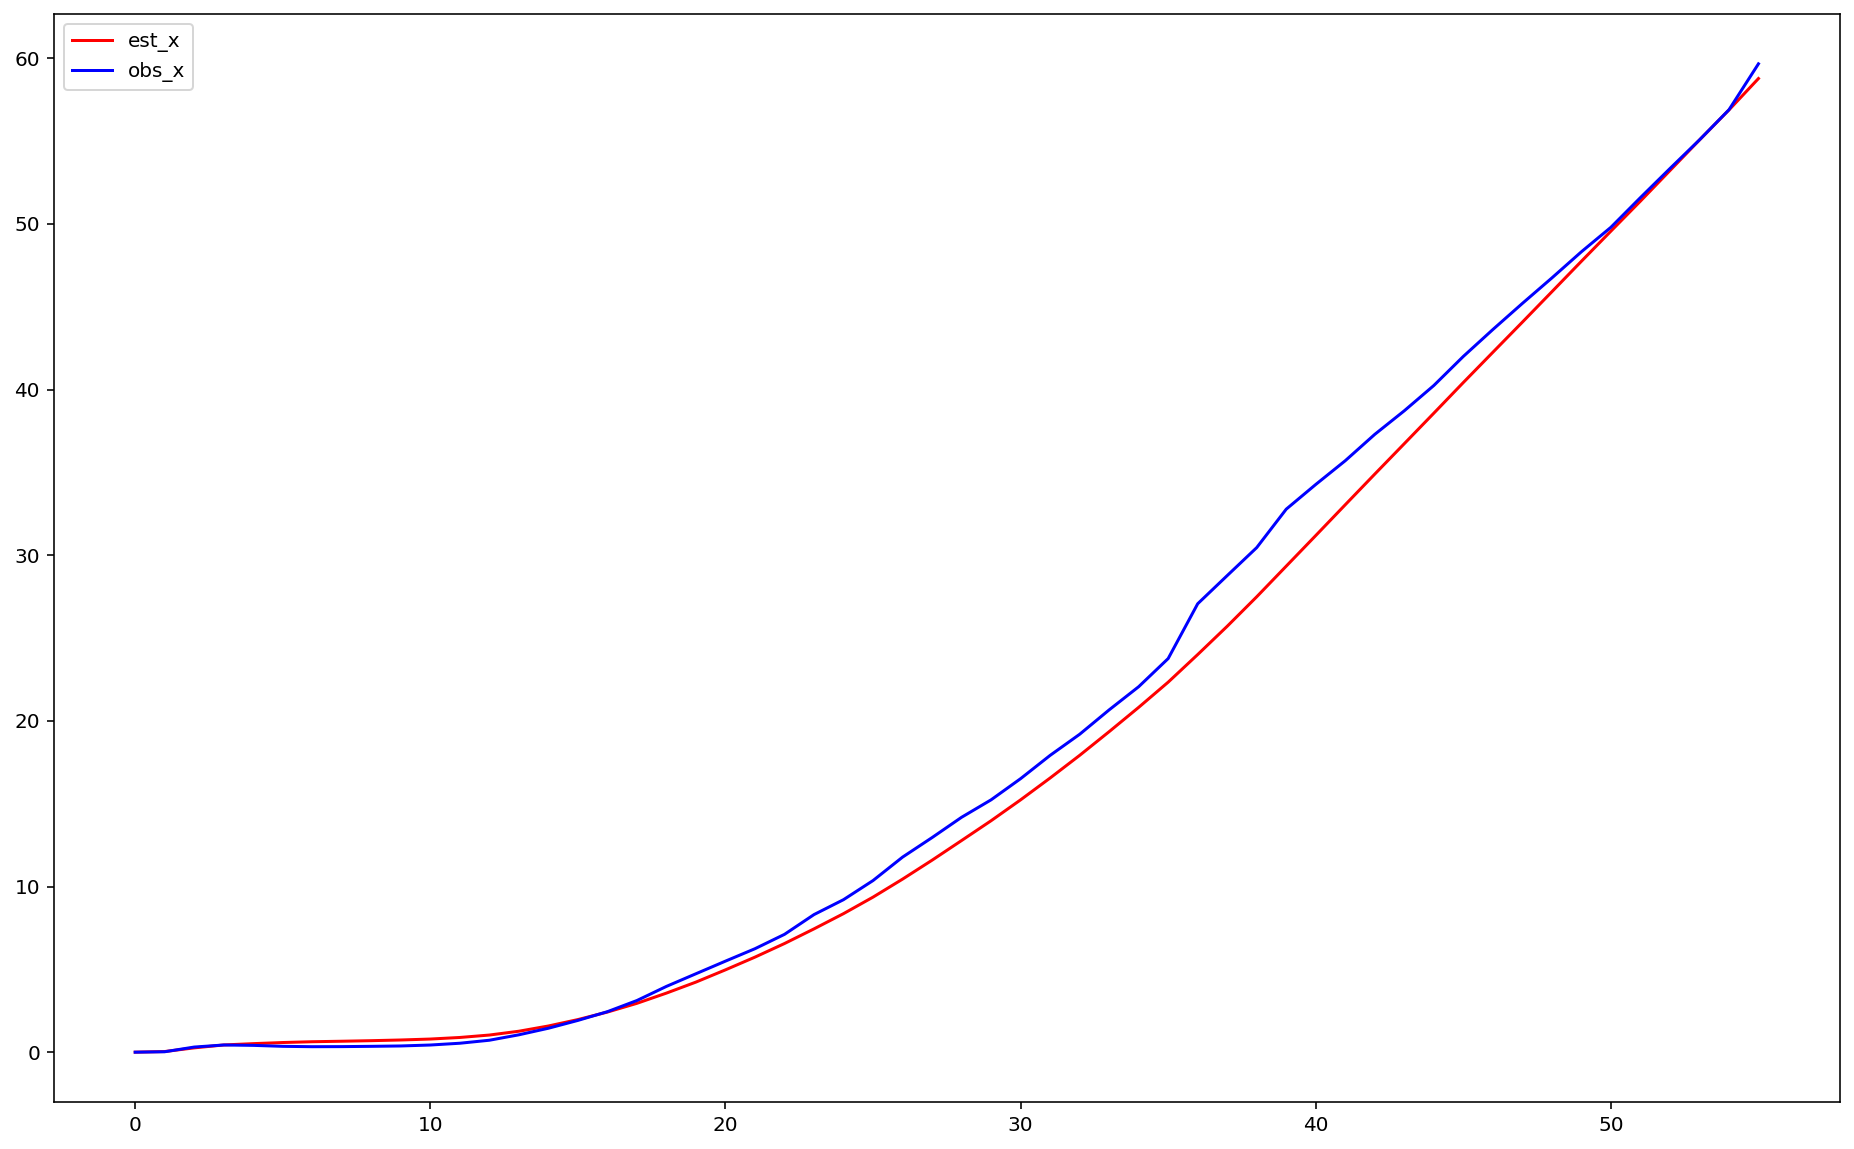

In [238]:
ax = df_est.est_x.plot(figsize=(16,10), color="red")
mx.obs_x.plot(ax=ax, color="blue")
ax.legend()

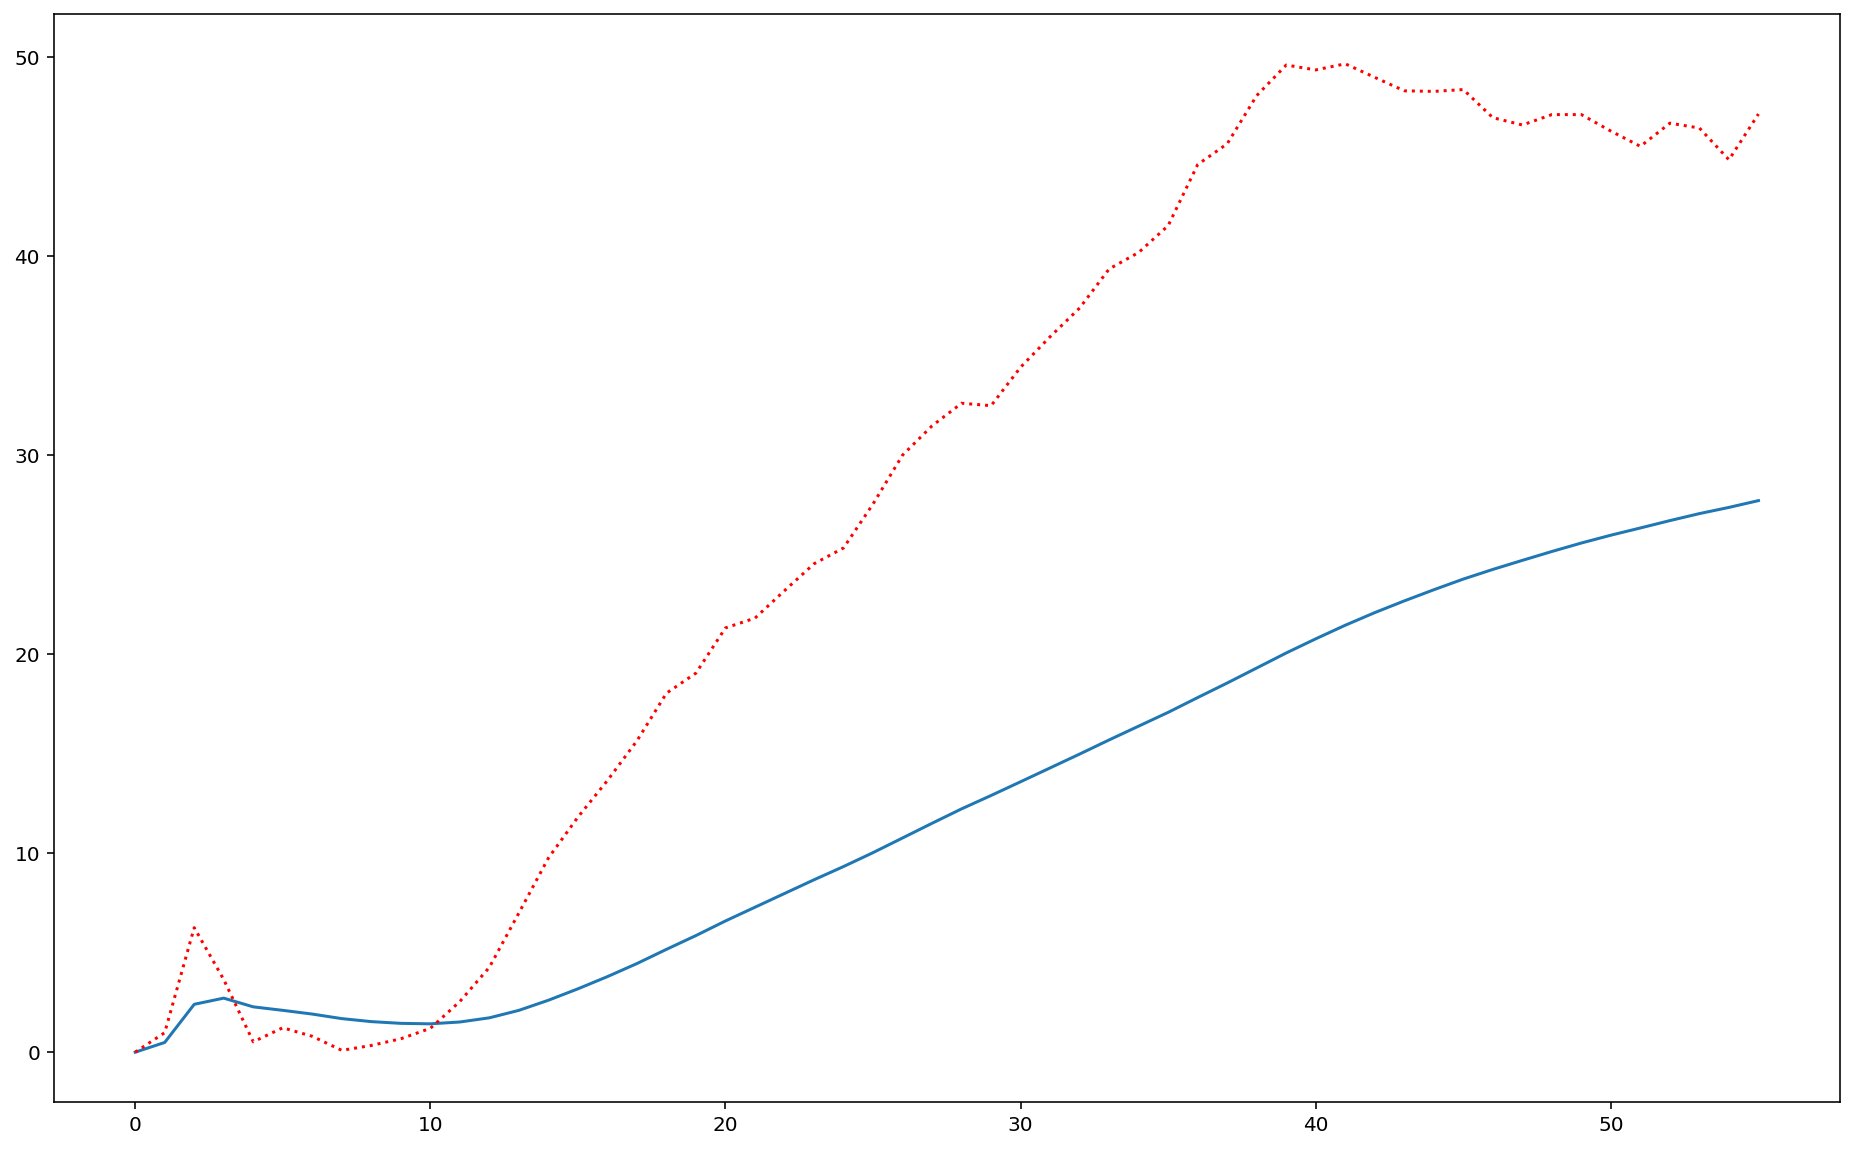

In [211]:
ax = df_est.est_Vx.plot(figsize=(16,10))
np.abs(mx.obs_Vx).plot(ax=ax, style='r:')

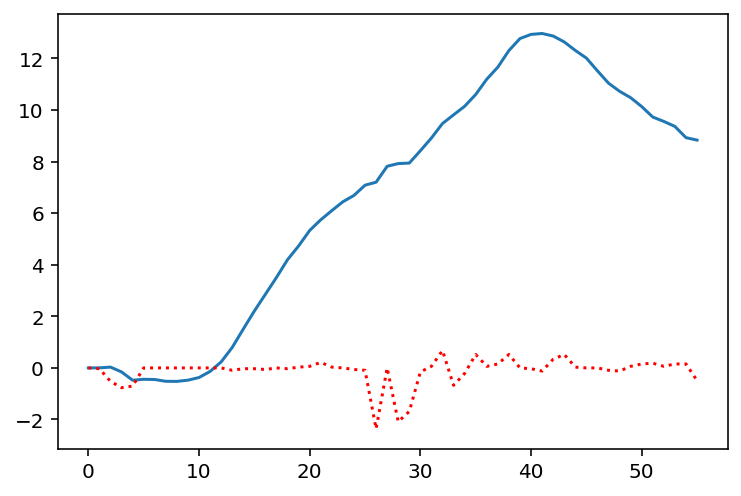

In [176]:
ax = df_est.est_Vy.plot()
mx.obs_Vy.plot(ax=ax, style='r:')